Нормализация данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

df = pd.read_csv(os.path.join('..', '..', 'data', 'ForUbung', 'neo_task.csv'))

x = lambda x: x.mean() if x.notna().any() else 0
group = df.groupby('miss_distance')['relative_velocity'].transform('mean').iat[0]
df['relative_velocity'].fillna(group, inplace=True)

x = lambda x: x.median() if x.notna().any() else 0
group = df.groupby('est_diameter_min')['absolute_magnitude'].transform(x)
df['absolute_magnitude'].fillna(group, inplace=True)

table = df['est_diameter_max'] - df['est_diameter_min']
df['est_diameter_max'].fillna(df['est_diameter_min'] + table.mean(), inplace=True)

df['name'].fillna('0 unknow', inplace=True)

df['id'].fillna(df['id'].mode()[1], inplace=True)

df.loc[df['absolute_magnitude'] == 0]
df = df.drop(index=df.loc[df['absolute_magnitude'] == 0].index)

dict_patch = {
    False: 0,
    True: 1
}
df['hazardous'] = df['hazardous'].map(dict_patch)

Баланс классов

In [2]:
from imblearn.under_sampling import RandomUnderSampler
X = df.drop(['name', 'hazardous', 'est_diameter_max'], axis=1)
Y = df['hazardous']
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X, Y)

Выделение обучающей и тестовой выборки

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.2, random_state=42, stratify=y_resampled)

# DTs

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

# GridSearchCV
cart_best_grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              cart_params,
                              cv=5,
                              verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


Gini

In [5]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

clf_gini.fit(X_train, y_train)

y_pred_gini = clf_gini.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_gini))

0.8737980769230769


In [7]:
print(clf_gini.score(X_train, y_train))
print(clf_gini.score(X_test, y_test))

0.8747171945701357
0.8737980769230769


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

           0       0.99      0.75      0.86      7072
           1       0.80      0.99      0.89      7072

    accuracy                           0.87     14144
   macro avg       0.90      0.87      0.87     14144
weighted avg       0.90      0.87      0.87     14144



[Text(0.5416666666666666, 0.875, 'x[4] <= 22.005\ngini = 0.5\nsamples = 3536\nvalue = [1768, 1768]'),
 Text(0.3333333333333333, 0.625, 'x[3] <= 22028141.0\ngini = 0.324\nsamples = 2205\nvalue = [448, 1757]'),
 Text(0.16666666666666666, 0.375, 'x[3] <= 12245388.5\ngini = 0.114\nsamples = 479\nvalue = [29, 450]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.04\nsamples = 246\nvalue = [5, 241]'),
 Text(0.25, 0.125, 'gini = 0.185\nsamples = 233\nvalue = [24, 209]'),
 Text(0.5, 0.375, 'x[2] <= 13707.417\ngini = 0.368\nsamples = 1726\nvalue = [419, 1307]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.255\nsamples = 20\nvalue = [17, 3]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.36\nsamples = 1706\nvalue = [402, 1304]'),
 Text(0.75, 0.625, 'x[1] <= 0.092\ngini = 0.016\nsamples = 1331\nvalue = [1320, 11]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 1275\nvalue = [1275, 0]'),
 Text(0.8333333333333334, 0.375, 'x[0] <= 3213910.0\ngini = 0.316\nsamples = 56\nvalue = [45, 11]'),
 Tex

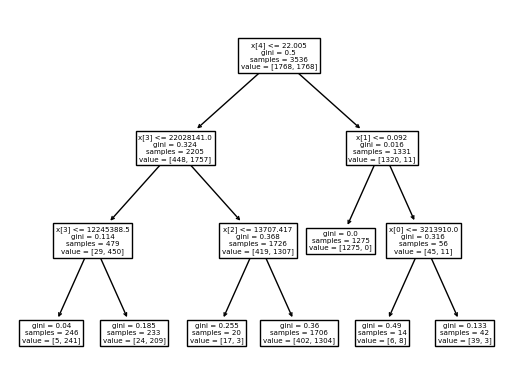

In [9]:
from sklearn import tree
tree.plot_tree(clf_gini.fit(X_train, y_train))

In [10]:
from sklearn.tree import export_text

tree_rules = export_text(clf_gini, feature_names=list(X.columns))
print(tree_rules)

|--- absolute_magnitude <= 22.01
|   |--- miss_distance <= 22028141.00
|   |   |--- miss_distance <= 12245388.50
|   |   |   |--- class: 1
|   |   |--- miss_distance >  12245388.50
|   |   |   |--- class: 1
|   |--- miss_distance >  22028141.00
|   |   |--- relative_velocity <= 13707.42
|   |   |   |--- class: 0
|   |   |--- relative_velocity >  13707.42
|   |   |   |--- class: 1
|--- absolute_magnitude >  22.01
|   |--- est_diameter_min <= 0.09
|   |   |--- class: 0
|   |--- est_diameter_min >  0.09
|   |   |--- id <= 3213910.00
|   |   |   |--- class: 1
|   |   |--- id >  3213910.00
|   |   |   |--- class: 0



Entropy

In [11]:
from sklearn.tree import DecisionTreeClassifier

clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

clf_entropy.fit(X_train, y_train)

y_pred_entropy = clf_entropy.predict(X_test)

y_pred_train_entropy = clf_entropy.predict(X_train)

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_entropy))

0.8737273755656109


In [13]:
print(clf_entropy.score(X_train, y_train))
print(clf_entropy.score(X_test, y_test))

0.8752828054298643
0.8737273755656109


In [14]:
from sklearn.metrics import classification_report, roc_auc_score


In [15]:
print(classification_report(y_test, y_pred_entropy))

              precision    recall  f1-score   support

           0       0.99      0.75      0.86      7072
           1       0.80      0.99      0.89      7072

    accuracy                           0.87     14144
   macro avg       0.90      0.87      0.87     14144
weighted avg       0.90      0.87      0.87     14144



[Text(0.5416666666666666, 0.875, 'x[4] <= 22.005\ngini = 0.5\nsamples = 3536\nvalue = [1768, 1768]'),
 Text(0.3333333333333333, 0.625, 'x[3] <= 22028141.0\ngini = 0.324\nsamples = 2205\nvalue = [448, 1757]'),
 Text(0.16666666666666666, 0.375, 'x[3] <= 12245388.5\ngini = 0.114\nsamples = 479\nvalue = [29, 450]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.04\nsamples = 246\nvalue = [5, 241]'),
 Text(0.25, 0.125, 'gini = 0.185\nsamples = 233\nvalue = [24, 209]'),
 Text(0.5, 0.375, 'x[2] <= 13707.417\ngini = 0.368\nsamples = 1726\nvalue = [419, 1307]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.255\nsamples = 20\nvalue = [17, 3]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.36\nsamples = 1706\nvalue = [402, 1304]'),
 Text(0.75, 0.625, 'x[1] <= 0.092\ngini = 0.016\nsamples = 1331\nvalue = [1320, 11]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 1275\nvalue = [1275, 0]'),
 Text(0.8333333333333334, 0.375, 'x[0] <= 3213910.0\ngini = 0.316\nsamples = 56\nvalue = [45, 11]'),
 Tex

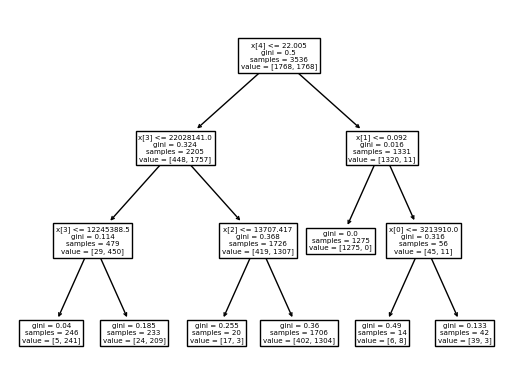

In [16]:
tree.plot_tree(clf_gini.fit(X_train, y_train))

In [17]:
from sklearn.tree import export_text

tree_rules = export_text(clf_entropy, feature_names=list(X.columns))
print(tree_rules)

|--- absolute_magnitude <= 22.05
|   |--- miss_distance <= 22028141.00
|   |   |--- absolute_magnitude <= 22.01
|   |   |   |--- class: 1
|   |   |--- absolute_magnitude >  22.01
|   |   |   |--- class: 0
|   |--- miss_distance >  22028141.00
|   |   |--- relative_velocity <= 13707.42
|   |   |   |--- class: 0
|   |   |--- relative_velocity >  13707.42
|   |   |   |--- class: 1
|--- absolute_magnitude >  22.05
|   |--- est_diameter_min <= 0.09
|   |   |--- class: 0
|   |--- est_diameter_min >  0.09
|   |   |--- id <= 3213910.00
|   |   |   |--- class: 1
|   |   |--- id >  3213910.00
|   |   |   |--- class: 0



In [18]:
from pycaret.classification import *

setup(data=df,  target='hazardous',ignore_features=['name'] , session_id=555, train_size=0.3, preprocess=True)

models()

,Description,Value
0,Session id,555
1,Target,hazardous
2,Target type,Binary
3,Original data shape,"(90835, 8)"
4,Transformed data shape,"(90835, 7)"
5,Transformed train set shape,"(27250, 7)"
6,Transformed test set shape,"(63585, 7)"
7,Ignore features,1
8,Numeric features,6
9,Preprocess,True


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [19]:
dt = create_model(estimator='dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9130,0.7650,0.5811,0.5500,0.5651,0.5169,0.5171
1,0.9046,0.7333,0.5208,0.5092,0.5149,0.4620,0.4621
2,0.8972,0.7124,0.4830,0.4723,0.4776,0.4206,0.4207
3,0.9068,0.7497,0.5547,0.5194,0.5365,0.4847,0.4851
4,0.9127,0.7395,0.5245,0.5538,0.5388,0.4906,0.4908
5,0.9013,0.7231,0.5019,0.4926,0.4972,0.4425,0.4425
6,0.9046,0.7434,0.5434,0.5088,0.5255,0.4726,0.4729
7,0.9053,0.7371,0.5283,0.5128,0.5204,0.4679,0.4680
8,0.9057,0.7281,0.5075,0.5172,0.5123,0.4601,0.4602


CART

In [20]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)


y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      7072
           1       0.83      0.82      0.83      7072

    accuracy                           0.83     14144
   macro avg       0.83      0.83      0.83     14144
weighted avg       0.83      0.83      0.83     14144



In [21]:
roc_auc_score(y_test, y_prob)

0.8286906108597285

In [22]:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=3,
                              n_jobs=-1,
                              verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [23]:
cart_best_grid.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [24]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_,
                                    random_state=17).fit(X_train, y_train)

y_pred = cart_final.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      7072
           1       0.80      0.99      0.89      7072

    accuracy                           0.87     14144
   macro avg       0.90      0.87      0.87     14144
weighted avg       0.90      0.87      0.87     14144



[Text(0.6041666666666666, 0.9, 'x[4] <= 22.005\ngini = 0.5\nsamples = 3536\nvalue = [1768, 1768]'),
 Text(0.3333333333333333, 0.7, 'x[3] <= 22028141.0\ngini = 0.324\nsamples = 2205\nvalue = [448, 1757]'),
 Text(0.16666666666666666, 0.5, 'x[3] <= 12245388.5\ngini = 0.114\nsamples = 479\nvalue = [29, 450]'),
 Text(0.08333333333333333, 0.3, 'x[2] <= 74904.422\ngini = 0.04\nsamples = 246\nvalue = [5, 241]'),
 Text(0.041666666666666664, 0.1, 'gini = 0.01\nsamples = 207\nvalue = [1, 206]'),
 Text(0.125, 0.1, 'gini = 0.184\nsamples = 39\nvalue = [4, 35]'),
 Text(0.25, 0.3, 'x[3] <= 12268512.5\ngini = 0.185\nsamples = 233\nvalue = [24, 209]'),
 Text(0.20833333333333334, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.2916666666666667, 0.1, 'gini = 0.179\nsamples = 232\nvalue = [23, 209]'),
 Text(0.5, 0.5, 'x[2] <= 13707.417\ngini = 0.368\nsamples = 1726\nvalue = [419, 1307]'),
 Text(0.4166666666666667, 0.3, 'x[0] <= 2467227.0\ngini = 0.255\nsamples = 20\nvalue = [17, 3]'),
 Text(0.375

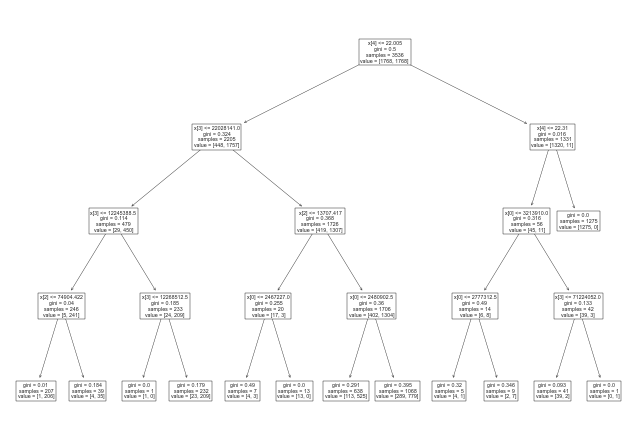

In [25]:
tree.plot_tree(cart_final.fit(X_train, y_train))

In [26]:
tree_rules = export_text(cart_final, feature_names=list(X.columns))
print(tree_rules)

|--- absolute_magnitude <= 22.01
|   |--- miss_distance <= 22028141.00
|   |   |--- miss_distance <= 12245388.50
|   |   |   |--- relative_velocity <= 74904.42
|   |   |   |   |--- class: 1
|   |   |   |--- relative_velocity >  74904.42
|   |   |   |   |--- class: 1
|   |   |--- miss_distance >  12245388.50
|   |   |   |--- miss_distance <= 12268512.50
|   |   |   |   |--- class: 0
|   |   |   |--- miss_distance >  12268512.50
|   |   |   |   |--- class: 1
|   |--- miss_distance >  22028141.00
|   |   |--- relative_velocity <= 13707.42
|   |   |   |--- id <= 2467227.00
|   |   |   |   |--- class: 0
|   |   |   |--- id >  2467227.00
|   |   |   |   |--- class: 0
|   |   |--- relative_velocity >  13707.42
|   |   |   |--- id <= 2480902.50
|   |   |   |   |--- class: 1
|   |   |   |--- id >  2480902.50
|   |   |   |   |--- class: 1
|--- absolute_magnitude >  22.01
|   |--- absolute_magnitude <= 22.31
|   |   |--- id <= 3213910.00
|   |   |   |--- id <= 2777312.50
|   |   |   |   |--- clas

Ансамбли

In [29]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier().fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7072
           1       0.83      0.89      0.86      7072

    accuracy                           0.85     14144
   macro avg       0.86      0.85      0.85     14144
weighted avg       0.86      0.85      0.85     14144



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

grad_clf = GradientBoostingClassifier().fit(X_train, y_train)

y_pred = grad_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      7072
           1       0.81      0.98      0.88      7072

    accuracy                           0.87     14144
   macro avg       0.89      0.87      0.87     14144
weighted avg       0.89      0.87      0.87     14144



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

stack_clf = StackingClassifier(estimators=[
                                         ('en', DecisionTreeClassifier(criterion='entropy')),
                                         ('gini', DecisionTreeClassifier(criterion='gini'))], final_estimator=KNeighborsClassifier(10)).fit(X_train, y_train)

y_pred = stack_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      7072
           1       0.81      0.93      0.87      7072

    accuracy                           0.86     14144
   macro avg       0.87      0.86      0.86     14144
weighted avg       0.87      0.86      0.86     14144



CatBoost Classifier

Принцип работы CatBoost Classifier основан на градиентном бустинге. Алгоритм обучения состоит в последовательном построении ансамбля слабых моделей, каждая из которых участвует в предсказании и исправляет ошибки предыдущих моделей. Это позволяет достичь высокой точности классификации и предсказания в случаях, когда данные имеют сложную структуру и сильные нелинейности.

In [ ]:
from catboost import CatBoostClassifier

CatBoostclf = CatBoostClassifier(iterations=2, depth=3).fit(X_train, y_train)

y_pred = CatBoostclf.predict(X_test)

print(classification_report(y_test, y_pred))

Learning rate set to 0.5
0:	learn: 0.4780744	total: 2.21ms	remaining: 2.21ms
1:	learn: 0.3908364	total: 5.25ms	remaining: 0us
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      7072
           1       0.79      0.99      0.88      7072

    accuracy                           0.87     14144
   macro avg       0.89      0.87      0.86     14144
weighted avg       0.89      0.87      0.86     14144



CART

In [ ]:
class Node:
    def __init__(self, depth: int) -> None:
        self.value = None                   # кол-во элементов
        self.left: Node = None
        self.right: Node = None
        self.depht: int = depth             # глубина вершины
    
    def get_left_node(self):
        if not self.left:
            self.left = Node(self.depht + 1)
            
    def get_right_node(self):
        if not self.right:
            self.right = Node(self.depht + 1)

In [ ]:
class Split:
    def __init__(self, feature, threshold):
        self.feature = feature
        self.threshold = threshold

In [ ]:
class CARTNodeData:
    def __init__(self, split, X, y) -> None:
        self.split: Split = split
        self.X = X
        self.y = y

In [ ]:
class CARTClassifir:
    def __init__(self, max_depht: 4):
        self.max_depht = max_depht
        self.tree_root: Node = Node(depth=0)
    
    def fit(self, X_tr, y_tr):
        self.__build_children(self.tree_root, X_tr, y_tr)
        
    def predict(self, X_test: pd.DataFrame):
        y_pred = []
        for index, feature in X_test.iterrows():
            depth = 0
            node = self.tree_root
            while(depth != self.max_depht):
                if feature[node.value.split.feature] > node.value.split.threshold:
                    node = node.right
                else:
                    node = node.left
                depth += 1
            y_pred.append(node.value.split.y.mode())
            
        return y_pred
    
    
    def __build_children(self, node: Node, X: pd.DataFrame, y: pd.DataFrame):
        split = self.__best_split(X, y)
        
        node.value = CARTNodeData(split, X, y)
        data_left_x, data_left_y, data_right_x, data_right_y = self.__split_data(X, y, split)
        
        if node.depht <= self.max_depht:
            self.__build_children(node.get_left_node(), data_left_x, data_left_y)
            self.__build_children(node.get_right_node(), data_right_x, data_right_y)
        
    def __best_split(self, X: pd.DataFrame, y: pd.DataFrame) -> Split:
        features = X.columns
        best_split = Split()
        best_gain = float('inf')
        
        for feature in features:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                split = Split(feature, threshold)
                gain = self.__info_gain(X, y, split, self.calc_answer)
                if gain < best_gain:
                    best_split = split
                    best_gain = gain
        
        return best_split
    
    def __info_gain(self, X: pd.DataFrame, y: pd.DataFrame, split: Split) -> int:
        data_left_x, data_left_y, data_right_x, data_right_y = self.__split_data(X, y, split)
        G = data_left_y.count() / y.count() * self.__gini_index(y, data_left_y, data_right_y) + data_right_y.count() / y.count() * self.__gini_index(y, data_left_y, data_right_y)
        return G
    
    def __split_data(self, X: pd.DataFrame, y: pd.DataFrame, split: Split) -> list(pd.DataFrame):
        X_left = X.transform(lambda x: x <= split.threshold).to_numpy()
        X_right = X.transform(lambda x: x > split.threshold).to_numpy()
        y_left = y.to_numpy().take(X_left.index.to_numpy())
        y_right = y.to_numpy().take(X_right.index.to_numpy())
        
        X_left = pd.DataFrame(X_left)
        X_right = pd.DataFrame(X_right)
        y_left = pd.DataFrame(y_left)
        y_right = pd.DataFrame(y_right)
        
        return list(X_left, y_left, X_right, y_right)
        
    def __gini_index(self, y: pd.DataFrame, y_left: pd.DataFrame, y_right: pd.DataFrame) -> int:
        G_index = 1 - sum( (y_left.count() / y.count()) ** 2 + (y_right.count() / y.count()) ** 2 )
        return G_index